In [1]:
import numpy as np
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')
from mpl_toolkits import mplot3d as mpl3d
from scipy import signal, stats, linalg, fft

# import our 'specsens' package with the help of 'sys'
import sys
sys.path.insert(0, '..')
import specsens as ss

In [2]:
# mpl.use("pgf")  # to display graphs remove this line
mpl.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
line = 0.75

In [3]:
# general settings for signal and noise
length = 0.1  # in s
noise_power = 0.0  # in dB

num_bands = 40

# create 'WidebandSignal' object
wbs = ss.WidebandSignal(t_sec=length,
                        num_bands=num_bands,
                        num_steps=1,
                        band_width=0.25e5)

# signal power matrix (dimensions: num_bands x num_steps)
mat = np.array([[-100], [-100], [-100], [0], [0], [0], [0], [-100], [-100],
                [-100], [-100], [0], [-100], [-100], [10], [10], [-100], [-100],
                [-100], [-100], [-100], [-100], [-100], [0], [0], [0], [0], [0], [0],
                [-100], [-100], [-100], [-100], [-100], [-100], [5], [-100], [-100],
                [-100], [-100]])

# # plot the matrix
# wbs.plot(mat)

# generate actual signal from matrix
sig, sample_freq = wbs.signal(mat)

# create the noise
wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.signal(power=noise_power, dB=True)

# ensure noise and signal have same length (and create global variable 'num_samples')
assert wbs.num_samples == wgn.num_samples
num_samples = wbs.num_samples

# create actual signal ('both') comprising of signal and additive white Gaussian noise (AWGN)
both = sig + noise

# print some info about signal and noise
print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num samples:  %d ' % (num_samples))

# ensure that Parseval's theorem holds
ss.util.check_parseval(both, length, sample_freq)

Created WidebandSignal with 1.0 MHz total bandwidth and 100000 samples per step.
Signal power: 15.34 dB
Noise power:  0.00 dB
SNR:          15.34 dB
Num samples:  100000 


In [4]:
# create a Short Time Fourier Transform object
sft = ss.Stft(n=1024, window='flattop')

# use the stft to transform the signal into the frequency domain
f, t, x = sft.spectogram(both, sample_freq, normalized=True, dB=True)

# smooth the spectrum by averaging (Bartlett's method)
psd = ss.util_wide.psd_average(spectogram=x, start=10, stop=20)

# detect edges in spectrum
prod, peak, peakf = ss.edge_detector(
    psd,
    f,
    scale=4,  # number of multi-scale wavelet products
    min_height=0.1,  # min height required
    min_freq=2e4)  # min frequency spacing required

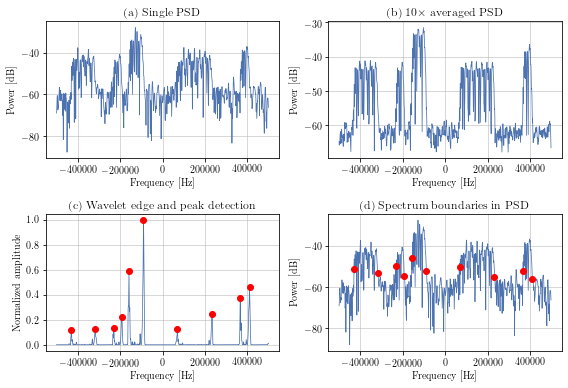

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 5.5))

axs[0, 0].plot(f, x[:, 1], linewidth=0.75, aa=True)
axs[0, 0].grid(linewidth=0.5)
axs[0, 0].set_title(r'(a) Single PSD')
axs[0, 0].set_xlabel(r"Frequency [Hz]")
axs[0, 0].set_ylabel(r"Power [dB]")

axs[0, 1].plot(f, psd, linewidth=0.75, aa=True)
axs[0, 1].grid(linewidth=0.5)
axs[0, 1].set_title(r'(b) $10\times$ averaged PSD')
axs[0, 1].set_xlabel(r"Frequency [Hz]")
axs[0, 1].set_ylabel(r"Power [dB]")

axs[1, 0].plot(f, prod, linewidth=0.75, aa=True)
axs[1, 0].plot(peakf, prod[peak], 'ro')
axs[1, 0].grid(linewidth=0.5)
axs[1, 0].set_title(r'(c) Wavelet edge and peak detection')
axs[1, 0].set_xlabel(r"Frequency [Hz]")
axs[1, 0].set_ylabel(r"Normalized amplitude")

# axs[1,1].plot(f, psd, linewidth=0.75, aa=True)
axs[1, 1].plot(f, x[:, 1], linewidth=0.75, aa=True)
axs[1, 1].plot(peakf, psd[peak], 'ro')
axs[1, 1].grid(linewidth=0.5)
axs[1, 1].set_title(r'(d) Spectrum boundaries in PSD')
axs[1, 1].set_xlabel(r"Frequency [Hz]")
axs[1, 1].set_ylabel(r"Power [dB]")

plt.tight_layout()
plt.savefig('out/chap5/edge_detect.pdf')